In [1]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf

from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, SimpleRNN, Input, merge, Embedding, TimeDistributed
from keras.objectives import sparse_categorical_crossentropy, mean_squared_error

Using TensorFlow backend.


In [2]:
## Code taken from http://www.rigtorp.se/2011/01/01/rolling-statistics-numpy.html

def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

(196,)


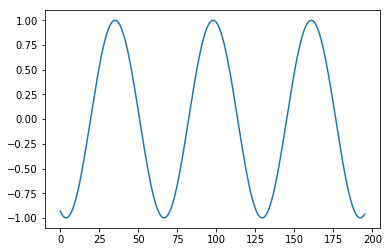

In [3]:
X = np.arange(-10,10,0.1)
X = np.cos(np.mean(rolling_window(X, 5), -1))
#X = X[:-5+1]
print(X.shape)
plt.plot(X)

Replicating data generation from http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [4]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [5]:
train_size = int(X.shape[0]*0.67)
test_size = X.shape[0] - train_size
train = X[:train_size]
test = X[train_size:]
print(train_size, train.shape, test_size, test.shape)

131 (131,) 65 (65,)


In [6]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(129, 1) (129,) (63, 1) (63,)


In [7]:
print(trainX[:10])
print(trainY[:10])

[[-0.93042627]
 [-0.96236488]
 [-0.98468786]
 [-0.99717216]
 [-0.99969304]
 [-0.99222533]
 [-0.97484362]
 [-0.9477216 ]
 [-0.91113026]
 [-0.86543521]]
[-0.96236488 -0.98468786 -0.99717216 -0.99969304 -0.99222533 -0.97484362
 -0.9477216  -0.91113026 -0.86543521 -0.81109301]


In [8]:
np.reshape(trainX[:10], (trainX[:10].shape[0], 1, trainX[:10].shape[1])).shape

(10, 1, 1)

In [9]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

## Keras model

In [10]:
model = Sequential()
model.add(LSTM(4, input_dim=look_back))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [11]:
model.fit(trainX, trainY, nb_epoch=10, batch_size=50)

Epoch 1/10
129/129 [==============================] - 7s - loss: 0.4783      
Epoch 2/10
129/129 [==============================] - 0s - loss: 0.4761     
Epoch 3/10
129/129 [==============================] - 0s - loss: 0.4738     
Epoch 4/10
129/129 [==============================] - 0s - loss: 0.4715     
Epoch 5/10
129/129 [==============================] - 0s - loss: 0.4691     
Epoch 6/10
129/129 [==============================] - 0s - loss: 0.4667     
Epoch 7/10
129/129 [==============================] - 0s - loss: 0.4642     
Epoc

In [12]:
pred_train = model.predict(trainX)
pred_test = model.predict(testX)
pred_train.shape, pred_test.shape

((129, 1), (63, 1))

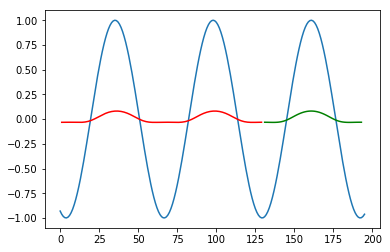

In [13]:
plt.plot(X)
plt.plot(np.arange(pred_train.shape[0])+1, pred_train, color='r')
plt.plot(np.arange(pred_test.shape[0])+train_size, pred_test, color='g')

In [14]:
model = Sequential()
model.add(SimpleRNN(4, input_dim=look_back))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=10, batch_size=5)

Epoch 1/10
129/129 [==============================] - 0s - loss: 1.0712     
Epoch 2/10
129/129 [==============================] - 0s - loss: 0.9684     

In [15]:
pred_train = model.predict(trainX)
pred_test = model.predict(testX)
pred_train.shape, pred_test.shape

((129, 1), (63, 1))

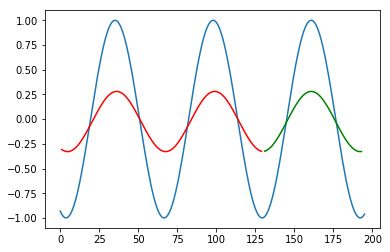

In [16]:
plt.plot(X)
plt.plot(np.arange(pred_train.shape[0])+1, pred_train, color='r')
plt.plot(np.arange(pred_test.shape[0])+train_size, pred_test, color='g')

In [17]:
trainX.shape

(129, 1, 1)

## Multi task learning Keras

In [18]:
X = np.random.randn(10,3)
W1 = np.random.randn(3,1)
W2 = np.random.randn(2,1)
y1 = np.dot(X, W1)
y2 = np.dot(X[:, :2], W2)

X.shape, y1.shape, y2.shape

((10, 3), (10, 1), (10, 1))

In [19]:
inp1 = Input(name="inp1", shape=(3,))
inp2 = Input(name="inp2", shape=(2,))

In [20]:
dense1 = Dense(10)(inp1)
merge_dens1_inp2 = merge([dense1, inp2], mode='concat')

In [21]:
dense2 = Dense(10)(merge_dens1_inp2)

In [22]:
out1 = Dense(1, name="out1")(dense1)
out2 = Dense(1, name="out2")(dense2)

In [23]:
model1 = Model(input=[inp1], output=[out1])

In [24]:
model1.get_output_at(0) == out1

True

In [25]:
model2 = Model(input=[inp1, inp2], output=[out2])

In [26]:
model1.compile(optimizer='sgd', loss='mean_squared_error')
model2.compile(optimizer='sgd', loss='mean_squared_error')

In [27]:
model2.predict([X, X[:, :2]])

array([[ 0.3986451 ],
       [-0.61922395],
       [ 0.46553299],
       [-0.0886135 ],
       [ 0.72533548],
       [ 0.02285887],
       [ 0.30524015],
       [ 0.19303803],
       [-0.06842817],
       [ 0.78346694]], dtype=float32)

In [28]:
model1.predict([X])

array([[ 0.76356345],
       [-1.10389507],
       [ 1.0578301 ],
       [-0.39246041],
       [ 1.21028972],
       [ 0.77841467],
       [ 0.66750604],
       [-0.25272202],
       [-0.48858267],
       [ 0.57783008]], dtype=float32)

In [29]:
model2.output_names

['out2']

In [30]:
model3 = Model(input=[inp1, inp2], output=[out1, out2])
model3.compile(optimizer='sgd', loss='mean_squared_error')

In [31]:
model3.predict([X, X[:, :2]])

[array([[ 0.76356345],
        [-1.10389507],
        [ 1.0578301 ],
        [-0.39246041],
        [ 1.21028972],
        [ 0.77841467],
        [ 0.66750604],
        [-0.25272202],
        [-0.48858267],
        [ 0.57783008]], dtype=float32), array([[ 0.3986451 ],
        [-0.61922395],
        [ 0.46553299],
        [-0.0886135 ],
        [ 0.72533548],
        [ 0.02285887],
        [ 0.30524015],
        [ 0.19303803],
        [-0.06842817],
        [ 0.78346694]], dtype=float32)]

## Multi output LSTM example

In [32]:
data = [[1,2,3,4,5],
        [2,3,2,2,2]
       ]
label_pos = [[1,2,2,2,1], None]
label_ner = [None, [1,1,1,2,1]]

In [33]:
input_seq = Input(shape=(5,), name="input_seq")
shared_embedding = Embedding(6, 10)(input_seq)

In [34]:
shared_embedding.get_shape()

TensorShape([Dimension(None), Dimension(5), Dimension(10)])

In [35]:
shared_layer = LSTM(10, return_sequences=True)(shared_embedding)
pos_layer = TimeDistributed(Dense(3, activation="softmax"), name="pos_labels")(shared_layer)
ner_layer = TimeDistributed(Dense(3, activation="softmax"), name="ner_labels")(shared_layer)

In [36]:
model = Model(input=input_seq, output=[pos_layer, ner_layer])

In [40]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', sample_weight_mode="temporal")

In [48]:
max_len = 5
X = np.array(data)
y_pos = np.expand_dims(np.array([np.zeros(max_len) if y is None else y for y in label_pos], dtype='int'), -1)
y_ner = np.expand_dims(np.array([np.zeros(max_len) if y is None else y for y in label_ner], dtype='int'), -1)
y_pos.shape, y_ner.shape

((2, 5, 1), (2, 5, 1))

In [49]:
pos_mask = np.array([np.ones(max_len)*(y is not None) for y in label_pos])
ner_mask = np.array([np.ones(max_len)*(y is not None) for y in label_ner])
pos_mask, ner_mask

(array([[ 1.,  1.,  1.,  1.,  1.],
        [ 0.,  0.,  0.,  0.,  0.]]), array([[ 0.,  0.,  0.,  0.,  0.],
        [ 1.,  1.,  1.,  1.,  1.]]))

In [50]:
model.fit(X, [y_pos, y_ner], sample_weight=[pos_mask, ner_mask])

Epoch 1/10
2/2 [==============================] - 1s - loss: 2.1965 - pos_labels_loss: 1.1076 - ner_labels_loss: 1.0889
Epoch 2/10
2/2 [==============================] - 0s - loss: 2.1888 - pos_labels_loss: 1.1046 - ner_labels_loss: 1.0842
Epoch 3/10
2/2 [==============================] - 0s - loss: 2.1811 - pos_labels_loss: 1.1015 - ner_labels_loss: 1.0796
Epoch 4/10
2/2 [==============================] - 0s - loss: 2.1736 - pos_labels_loss: 1.0985 - ner_labels_loss: 1.0751
Epoch 5/10
2/2 [==============================] - 0s - loss: 2.1661 - pos_labels_loss: 1.0955 - ner_labels_loss: 1.0706
Epoch 6/10
2/2 [==============================] - 0s - loss: 2.1587 - pos_labels_loss: 1.0926 - ner_labels_loss: 1.0661
Epoch 7/10
2/2 [==============================] - 0s - loss: 2.1514 - pos_labels_loss: 1.0896 - ner_labels_loss: 1.0617
Epoch 8/10
2/2 [==============================] - 0s - loss: 2.1441 - pos_labels_loss: 1.0868 - ner_labels_loss: 1.0574
Epoch 9/10
2/2 [========================

In [34]:
t = mean_squared_error(np.random.randn(10,2), np.random.randn(10,2))
t

<tf.Tensor 'Mean_24:0' shape=(10,) dtype=float64>

In [35]:
sess = tf.Session()
with sess.as_default():
    print(t.eval())

[ 1.3982274   6.17379382  2.69410353  0.3092882   0.43249701  0.38894633
  1.29343803  1.72605789  3.31974207  1.20314927]


In [36]:
t = mean_squared_error(np.random.randn(10,2,3), np.random.randn(10,2,3))
t

<tf.Tensor 'Mean_25:0' shape=(10, 2) dtype=float64>

In [37]:
sess = tf.Session()
with sess.as_default():
    print(t.eval())

[[ 1.05625593  0.32636009]
 [ 2.79147239  2.42880816]
 [ 3.6945321   0.89615701]
 [ 5.3059893   2.32529554]
 [ 1.23866607  1.52450653]
 [ 2.41590791  1.81906616]
 [ 5.68505985  0.51474718]
 [ 7.88741765  0.90664582]
 [ 2.27765413  1.38585867]
 [ 3.98567263  3.73537818]]


In [38]:
def custom_mse_loss(y_true, y_pred):
    loss_masks = y_true["masks"]
    y_true_vals = y_true["vals"]
    mse_loss = mean_squared_error(y_true_vals, y_pred)
    mse_loss_masked = loss_masks *  mse_loss
    return mse_loss_masked

In [39]:
y_pred = np.random.randn(10,5,3)
y_true_vals = np.random.randn(10,5,3)
y_true_masks = np.random.randint(2, size=(10,1))
y_true = {"masks": y_true_masks, "vals": y_true_vals}

In [40]:
t = custom_mse_loss(y_true, y_pred)
t

<tf.Tensor 'mul_109:0' shape=(10, 5) dtype=float64>

In [41]:
y_true_masks

array([[0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1]])

In [42]:
sess = tf.Session()
with sess.as_default():
    print(t.eval())

[[ 0.          0.          0.          0.          0.        ]
 [ 0.59259878  0.37469407  1.83470867  1.35303259  2.49079611]
 [ 1.02586168  4.83988508  0.31900125  2.57466262  1.25451509]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 1.22409462  1.64002248  2.09295172  0.85425327  4.29896931]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 4.69053322  2.86792321  2.00081542  1.0392119   1.21555662]]


In [57]:
pos_layer.get_shape()

TensorShape([Dimension(None), Dimension(None), Dimension(3)])

In [96]:
def task_based_loss(y_true, y_pred):
    print("Using layer: ", y_pred.get_shape(), y_pred.name)
    pos_labels = K.cast(y_true[:, :, 0], 'int64')
    ner_labels = K.cast(y_true[:, :, 1], 'int64')
    #pos_labels = K.cast(y_true[0][:, :, 0], 'int64')
    #ner_labels = K.cast(y_true[1][:, :, 0], 'int64')
    pos_preds = y_pred[0]
    ner_preds = y_pred[1]
    pos_loss = sparse_categorical_crossentropy(pos_labels, pos_preds)
    ner_loss = sparse_categorical_crossentropy(ner_labels, ner_preds)
    #pos_mask = y_true[0][:, :, 1] # POS mask channel
    #ner_mask = y_true[1][:, :, 1] # NER mask channel
    #pos_loss = pos_loss * pos_mask
    #ner_loss = ner_loss * ner_mask
    return (pos_loss + ner_loss)/2

In [97]:
model.compile(loss=task_based_loss, optimizer='sgd')

Using layer:  (?, ?, 3) Reshape_32:0
Using layer:  (?, ?, 3) Reshape_34:0


In [100]:
X.shape

(2, 5)

In [101]:
y_pos.shape, pos_mask.shape, y_ner.shape, ner_mask.shape

((2, 5), (2, 5), (2, 5), (2, 5))

ValueError: Error when checking model target: expected pos_labels to have 3 dimensions, but got array with shape (2, 5)

In [78]:
y_true = np.dstack([y_pos, y_ner, pos_mask, ner_mask])

In [80]:
y_true.shape

(2, 5, 4)

In [79]:
model.fit(X, y_true)

ValueError: The model expects 2 input arrays, but only received one array. Found: array with shape (2, 5, 4)

In [52]:
y_pred = model.predict(X)
y_pred[0].shape, y_pred[1].shape

((2, 5, 3), (2, 5, 3))

In [55]:
y_pred[0].argmax(axis=-1), y_pred[1].argmax(axis=-1)

(array([[2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2]]), array([[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1]]))